### Paper Information

* Title: Functional Neural Processes ([Louizos et al., 2019](https://arxiv.org/abs/1906.08324), NIPS 2019)
* Authors: Christos Louizos, Xiahan Shi, Klamer Schutte, Max Welling (2019)

### Main Ideas

* Bayesian neural networks have been an approach for incorporating uncertainty into neural networks. However, its empirical success has been limited because (1) inference over the weights of a deep network is challenging even with convenient approximations, and (2) it is not clear which prior distribution is appropriate for the weights of the over-parametrized model. Alternative approaches that avoid positing distributions over the weights arise naturally.

* Inspired by Gaussian Processes and Neural Processes ([Garnelo et al., 2018](https://arxiv.org/abs/1807.01622)), Functional Neural Processes (FNPs) parametrize stochastic processes by explicitly building random graphs among local latent variables. These graphs of dependencies specify the conditional distributions of the target points given some context points.

    <img src="images/functional-neural-processes/figure-1-2.png" alt="Drawing" style="width: 70%;"/>

### Methodology

* Similar to previous models in the Neural Process family ([Garnelo et al., 2018](https://arxiv.org/abs/1807.01622), [Garnelo et al., 2018](https://arxiv.org/abs/1807.01613)), a FNP aims to model a stochastic process by ensuring exchangeability and consistency, the two necessary conditions for [Kolmogorov Extension theorem](https://en.wikipedia.org/wiki/Kolmogorov_extension_theorem) and [de Finneti's theorem](https://en.wikipedia.org/wiki/De_Finetti%27s_theorem).

* The context points $R$ and the remaining points $M$ are first mapped to corresponding latent representations $\mathbf{U}_R$ and $\mathbf{U}_M$ via a neural network. Two directed graphs are built on top of these representations: a directly acyclic graph $\mathbf{G}$ among the points in $R$ and a bipartite graph $\mathbf{A}$ from $R$ to $M$ (both $\mathbf{G}$ and $\mathbf{A}$ are random adjacency matrices). These graphs specify a topological ordering where the context points depend on each other and the remaining points depend only on the context points.

* More specifically, a stochastic ordering based on a parameter-free projection $t$ is adopted to avoid cycles in $\mathbf{G}$:

    $$p(\mathbf{G} \lvert \mathbf{U}_R) = \prod_{i \in R} \prod_{j \in R, j \neq i} \text{Bern}(\mathbf{G}_{ij} \lvert \mathbb{I}\{t(\mathbf{u}_i) > t(\mathbf{u}_j)\} \, g(\mathbf{u}_i, \mathbf{u}_j)),$$

    where $g(\mathbf{u}_i, \mathbf{u}_j)$ denotes the probability that a point $i$ depends on a point $j$. We can encode inductive biases via $g$ to convey a notion of similarity, such as $g(\mathbf{u}_i, \mathbf{u}_j) = \exp(-\frac{\tau}{2} \|\mathbf{u}_i - \mathbf{u}_j\|^2)$. The same function $g$ can be used to build the bipartite graph $\mathbf{A}$:

    $$p(\mathbf{A} \lvert \mathbf{U}_R, \mathbf{U}_M) = \prod_{i \in M} \prod_{j \in R} \text{Bern}(\mathbf{A}_{ij} \lvert g(\mathbf{u}_i, \mathbf{u}_j).$$

* Next, a local latent variable $\mathbf{z}_i$ for each point in $B = R \cup M$ summarizes all of the dependencies of the point on its parents. The predictive distribution is specified via these local random variables:

    $$\begin{align*}p(\mathbf{y}_B \lvert R, \mathbf{G}, \mathbf{A}) &= \int p_\theta(\mathbf{y}_B, \mathbf{Z}_B \lvert R, \mathbf{G}, \mathbf{A}) \, d\mathbf{Z}_B = \int p_\theta(\mathbf{y}_R, \mathbf{Z}_R \lvert R, \mathbf{G}) \, d\mathbf{Z}_R \, \int p_\theta(\mathbf{y}_M, \mathbf{Z}_M \lvert R, \mathbf{y}_R, \mathbf{A}) \, d\mathbf{Z}_M \\
    &= \prod_{i \in R} \int p_\theta (\mathbf{z}_i \lvert \text{par}_{\mathbf{G}_i}(R, \mathbf{y}_R)) p_\theta (y_i \lvert \mathbf{z}_i) \, d \mathbf{z}_i  \,  \prod_{j \in M} \int p_\theta (\mathbf{z}_j \lvert \text{par}_{\mathbf{A}_j}(R, \mathbf{y}_R)) p_\theta (y_j \lvert \mathbf{z}_j) \, d \mathbf{z}_j .\end{align*}$$

    To ensure permutation variance with respect to the parents, each distribution $p_\theta (\mathbf{z}_i \lvert \text{par}_{\mathbf{A}_i}(R, \mathbf{y}_R))$ is modeled as a Gaussian where each dimension $k$ corresponds to an independent distribution. In addition, the prediction distribution can also be allowed to depend directly on the representations $\mathbf{U}_B$, i.e. $p(\mathbf{y}_B \lvert R, \mathbf{U}_B, \mathbf{G}, \mathbf{A})$.

* The model is trained via variational inference, similar to Neural Processes ([Garnelo et al., 2018](https://arxiv.org/abs/1807.01622)). To backpropagate through the adjacency matrices $\mathbf{A}$ and $\mathbf{G}$ that are typically discrete, the Gumbel-softmax ([Jang et al., 2016](https://arxiv.org/abs/1611.01144)) trick is used.

### Related Works

* Comapred to CNPs ([Garnelo et al., 2018](https://arxiv.org/abs/1807.01613)) and Neural Processes ([Garnelo et al., 2018](https://arxiv.org/abs/1807.01613)), FNPs don't use global latent variables and incorporate cross-attention in the form of dependency graphs. Compared to Variational Implicit Processes ([Ma et al., 2018](https://arxiv.org/abs/1806.02390)) which considers Bayesian neural network (BNN) priors and use GPs for inference, FNPs circumvent the problem of imposing a meaningful prior over global parameters. Compared to Functional Variational Processes ([Sun et al., 2019](https://arxiv.org/abs/1903.05779)) which uses GP priors and use BNNs for inference, the marginal likelihood objective can be appealing.

### Experiments

* The authors conduct experiments with 1D function regressions. While MC-dropout and NP seem to be overconfident in the areas in-between data, they extrapolate better than FNP. The variant of $FNP$ that includes the dependency on $\mathbf{U}$ does help improve extrapolation.

    <img src="images/functional-neural-processes/figure-5.png" alt="Drawing" style="width: 80%;"/>

* The authors also consider an out-of-distribution detection task. The models appear sensitive to the number of context points $R$ as well as whether they are relevant to the target points.

    <img src="images/functional-neural-processes/table-1.png" alt="Drawing" style="width: 70%;"/>

### Thoughts

* The graphical approach seems complicated, and it is not clear the stochastic topological ordering on the dependency graphs results in any trade-offs. It is, however, a rather novel approach compared to other model in the neural process family.

### Implementation

The following implementation is based on [the official implementation](https://github.com/AMLab-Amsterdam/FNP).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from torchvision import datasets, transforms

import math
import numpy as np
from tqdm.notebook import tqdm


def logitexp(logp):
    # Convert log probability to logits (see https://github.com/pytorch/pytorch/issues/4007)
    pos = torch.clamp(logp, min=-0.69314718056)
    neg = torch.clamp(logp, max=-0.69314718056)
    neg_val = neg - torch.log(1 - torch.exp(neg))
    pos_val = -torch.log(torch.clamp(torch.expm1(-pos), min=1e-20))
    return pos_val + neg_val


class ClassificationFNP(nn.Module):
    def __init__(self, dim_x=(1, 28, 28), dim_y=10, use_plus=True, num_M=1, dim_u=32, dim_z=64, fb_z=1.0):
        """
        :param dim_x: Dimensionality of the input
        :param dim_y: Dimensionality of the output
        :param use_plus: Whether to use the FNP+
        :param num_M: How many points exist in the training set that are not part of the reference set
        :param dim_u: Dimensionality of the latents in the embedding space
        :param dim_z: Dimensionality of the  latents that summarize the parents
        :param fb_z: How many free bits do we allow for the latent variable z
        """
        super().__init__()
        self.dim_x, self.dim_y, self.dim_u, self.dim_z = dim_x, dim_y, dim_u, dim_z
        self.num_M, self.use_plus, self.fb_z = num_M, use_plus, fb_z

        self.x_encoder = nn.Sequential(nn.Conv2d(self.dim_x[0], 20, 5), nn.ReLU(), nn.MaxPool2d(2), nn.Conv2d(20, 50, 5), nn.ReLU(), nn.MaxPool2d(2), nn.Flatten(), nn.Linear(800, 500))
        self.p_u = nn.Sequential(nn.ReLU(), nn.Linear(500, 2 * self.dim_u))
        self.q_z = nn.Sequential(nn.ReLU(), nn.Linear(500, 2 * self.dim_z))

        self.y_encoder = nn.Linear(self.dim_y, 2 * self.dim_z)

        self.register_buffer("lambda_z", torch.tensor(1e-8))

        # For computing edge probabilities
        self.pairwise_g_logscale = nn.Parameter(torch.tensor(1.0 * dim_u).sqrt().log())

        # p(y|z) or p(y|z, u)
        self.output = nn.Sequential(nn.ReLU(), nn.Linear(self.dim_z if not self.use_plus else self.dim_z + self.dim_u, dim_y))

    def forward(self, XM, yM, XR, yR, kl_anneal=1.0):
        # Encode input images
        H_all = self.x_encoder(torch.cat([XR, XM], dim=0))

        # Approximate p(u | x) with a factorized Gaussian and draw a sample to construct a dependency graph
        pu_mean_all, pu_logscale_all = self.p_u(H_all).chunk(2, dim=1)
        pu = D.Normal(loc=pu_mean_all, scale=pu_logscale_all.exp())
        u = pu.rsample()

        # Compute soft adjacency matrices describing the dependency graph between
        # (1) samples from the reference set, denoted by G, using a stochastic ordering,
        # (2) samples from the current batch and those frm the reference set, denoted by A.
        G = self.sample_DAG(u[0 : XR.size(0)])
        A = self.sample_bipartite(u[XR.size(0) :], u[0 : XR.size(0)])

        # Approximate p(z | x) with a factorized Gaussian (prior distribution?)
        qz_mean_all, qz_logscale_all = self.q_z(H_all).chunk(2, dim=1)
        qz = D.Normal(loc=qz_mean_all, scale=qz_logscale_all.exp())
        z = qz.rsample()

        # Embed labels of reference points with another Gaussian
        cond_y_mean, cond_y_logscale = self.y_encoder(F.one_hot(yR, num_classes=self.dim_y).float()).chunk(2, dim=1)

        # For each point, gather label signals from its parent
        GA = F.normalize(torch.cat([G, A], dim=0), p=1, dim=1)
        pz_mean_all = torch.mm(GA, cond_y_mean + qz_mean_all[0 : XR.size(0)])
        pz_logscale_all = torch.mm(GA, cond_y_logscale + qz_logscale_all[0 : XR.size(0)])
        pz = D.Normal(loc=pz_mean_all, scale=pz_logscale_all.exp())

        # Compute KL(p(z | x) || q(z | x, yR))
        pqz_all = pz.log_prob(z) - qz.log_prob(z)

        # Apply free bits for the latent z
        if self.fb_z > 0:
            log_qpz = -torch.sum(pqz_all)
            if self.training:
                if log_qpz.item() > self.fb_z * z.size(0) * z.size(1) * (1 + 0.05):
                    self.lambda_z = torch.clamp(self.lambda_z * (1 + 0.1), min=1e-8, max=1.0)
                elif log_qpz.item() < self.fb_z * z.size(0) * z.size(1):
                    self.lambda_z = torch.clamp(self.lambda_z * (1 - 0.1), min=1e-8, max=1.0)
            log_pqz_R = self.lambda_z * torch.sum(pqz_all[0 : XR.size(0)])
            log_pqz_M = self.lambda_z * torch.sum(pqz_all[XR.size(0) :])
        else:
            log_pqz_R = torch.sum(pqz_all[0 : XR.size(0)])
            log_pqz_M = torch.sum(pqz_all[XR.size(0) :])

        final_rep = z if not self.use_plus else torch.cat([z, u], dim=1)
        logits_all = self.output(final_rep)
        log_pyR = -F.cross_entropy(input=logits_all[0 : XR.size(0)], target=yR, reduction="sum")
        log_pyM = -F.cross_entropy(input=logits_all[XR.size(0) :], target=yM, reduction="sum")

        obj_R = (log_pyR + log_pqz_R) / float(self.num_M)
        obj_M = (log_pyM + log_pqz_M) / float(XM.size(0))
        loss = -(obj_R + obj_M)
        return loss

    def predict(self, x_new, XR, yR, n_samples=100):
        H_all = self.x_encoder(torch.cat([XR, x_new], 0))
        pu_mean_all, pu_logscale_all = self.p_u(H_all).chunk(2, dim=1)
        pu = D.Normal(loc=pu_mean_all, scale=pu_logscale_all.exp())

        qz_mean_R, qz_logscale_R = self.q_z(H_all[0 : XR.size(0)]).chunk(2, dim=1)

        logits = x_new.new(x_new.size(0), self.dim_y, n_samples)
        for i in range(n_samples):
            u = pu.rsample()
            A = self.sample_bipartite(u[XR.size(0) :], u[0 : XR.size(0)])

            cond_y_mean, cond_y_logscale = self.y_encoder(F.one_hot(yR, num_classes=self.dim_y).float()).chunk(2, dim=1)
            A_norm = F.normalize(A, p=1, dim=1)
            pz_mean_M = torch.mm(A_norm, cond_y_mean + qz_mean_R)
            pz_logscale_M = torch.mm(A_norm, cond_y_logscale + qz_logscale_R)
            pz = D.Normal(loc=pz_mean_M, scale=pz_logscale_M.exp())

            z = pz.rsample()
            final_rep = z if not self.use_plus else torch.cat([z, u[XR.size(0) :]], dim=1)
            logits[:, :, i] = F.log_softmax(self.output(final_rep), 1)

        logits = torch.logsumexp(logits, 2) - math.log(n_samples)
        return logits

    def sample_DAG(self, Z, temperature=0.3):
        idx_utr = np.triu_indices(Z.size(0), 1)

        # Sort the latents according to the stochastic ordering
        ordering = (0.5 + 0.5 * torch.erf(Z / np.sqrt(2.0))).log().sum(dim=1, keepdim=True)
        sort_idx = torch.sort(torch.squeeze(ordering), 0)[1]
        Y = Z[sort_idx, :]

        # Get the logits for the edges in the DAG
        Z1, Z2 = Y[idx_utr[0]], Y[idx_utr[1]]
        logits = logitexp((-0.5 * ((Z1 - Z2) ** 2).sum(dim=1, keepdims=True) / self.pairwise_g_logscale.exp()).view(Z1.size(0), 1))

        if self.training:
            p_edges = D.relaxed_bernoulli.LogitRelaxedBernoulli(logits=logits, temperature=temperature)
            G = torch.sigmoid(p_edges.rsample())
        else:
            p_edges = D.Bernoulli(logits=logits)
            G = p_edges.sample()

        # Embed the upper triangular to the adjacency matrix
        unsorted_G = Z.new(Z.size(0), Z.size(0)).zero_()
        unsorted_G[idx_utr[0], idx_utr[1]] = G.squeeze()

        # Unsort the dag to conform to the data order
        original_idx = torch.sort(sort_idx)[1]
        unsorted_G = unsorted_G[original_idx, :][:, original_idx]
        return unsorted_G

    def sample_bipartite(self, Z1, Z2, temperature=0.3):
        indices = torch.cartesian_prod(torch.arange(len(Z1)), torch.arange(len(Z2)))
        Y1, Y2 = Z1[indices[:, 0]], Z2[indices[:, 1]]
        logits = logitexp((-0.5 * ((Y1 - Y2) ** 2).sum(dim=1, keepdims=True) / self.pairwise_g_logscale.exp()).view(Y1.size(0), 1))

        if self.training:
            p_edges = D.relaxed_bernoulli.LogitRelaxedBernoulli(logits=logits, temperature=temperature)
            A_vals = torch.sigmoid(p_edges.rsample())
        else:
            p_edges = D.Bernoulli(logits=logits)
            A_vals = p_edges.sample()

        # Embed the values to the adjacency matrix
        A = Z1.new(Z1.size(0), Z2.size(0)).zero_()
        A[indices[:, 0], indices[:, 1]] = A_vals.squeeze()
        return A


torch.manual_seed(0)
train_dataset = datasets.MNIST("/home/centos/data/mnist", train=True, transform=transforms.ToTensor())
train_dataset, ref_dataset = torch.utils.data.random_split(train_dataset, [59700, 300])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
ref_images = ref_dataset.dataset.data[ref_dataset.indices][:, None, :, :].float().div(255).cuda()
ref_labels = ref_dataset.dataset.targets[ref_dataset.indices].cuda()

valid_dataset = datasets.MNIST("/home/centos/data/mnist", train=False, transform=transforms.ToTensor())
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=100, shuffle=False)
model = ClassificationFNP(num_M=len(train_loader)).cuda()
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(10):
    model.train()
    train_loss = 0.0
    progress_bar = tqdm(train_loader, desc="Epoch {:02d}".format(epoch), leave=False)
    for batch_idx, (train_images, train_labels) in enumerate(progress_bar):
        train_images, train_labels = train_images.cuda(), train_labels.cuda()
        loss = model(train_images, train_labels, ref_images, ref_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        progress_bar.set_postfix_str("loss {:.3f}".format(loss.item()))

    model.eval()
    with torch.no_grad():
        correct, total = 0.0, 0.0
        progress_bar = tqdm(valid_loader, desc="Epoch {:02d}".format(epoch), leave=False)
        for valid_images, valid_labels in progress_bar:
            valid_images, valid_labels = valid_images.cuda(), valid_labels.cuda()
            logits = model.predict(valid_images, ref_images, ref_labels, n_samples=10)
            correct += torch.argmax(logits, 1).eq(valid_labels).sum().item()
            total += len(valid_labels)
            progress_bar.set_postfix_str("accuracy {:.3f}".format(correct / total))

    print("Epoch {:02d}: loss {:.3f}, accuracy {:.3f}".format(epoch, train_loss / len(train_loader), 100.0 * correct / total))

```
Epoch 00: loss 0.257, accuracy 96.960
Epoch 01: loss 0.053, accuracy 98.750
Epoch 02: loss 0.035, accuracy 98.760
Epoch 03: loss 0.028, accuracy 99.000
Epoch 04: loss 0.022, accuracy 98.860
Epoch 05: loss 0.017, accuracy 98.830
Epoch 06: loss 0.014, accuracy 98.860
Epoch 07: loss 0.012, accuracy 99.150
Epoch 08: loss 0.011, accuracy 98.930
Epoch 09: loss 0.010, accuracy 99.060
```

In [ ]:
from torchvision.datasets import FashionMNIST

test_dataset = datasets.FashionMNIST("/home/centos/data/fmnist", train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

model.eval()
with torch.no_grad():
    entropy, total = 0.0, 0.0
    progress_bar = tqdm(test_loader, leave=False)
    for test_images, test_labels in progress_bar:
        test_images, test_labels = test_images.cuda(), test_labels.cuda()
        logits = model.predict(test_images, ref_images, ref_labels, n_samples=100)
        probs = F.softmax(logits, dim=-1).clamp(min=1e-5, max=1 - 1e-5)
        entropy += -(probs * probs.log()).sum(dim=1).sum().item()
        total += len(test_labels)
        progress_bar.set_postfix_str("entropy {:.3f}".format(entropy / total))

print("OOD entropy {:.3f}".format(entropy / total))

```
OOD entropy 1.608
```

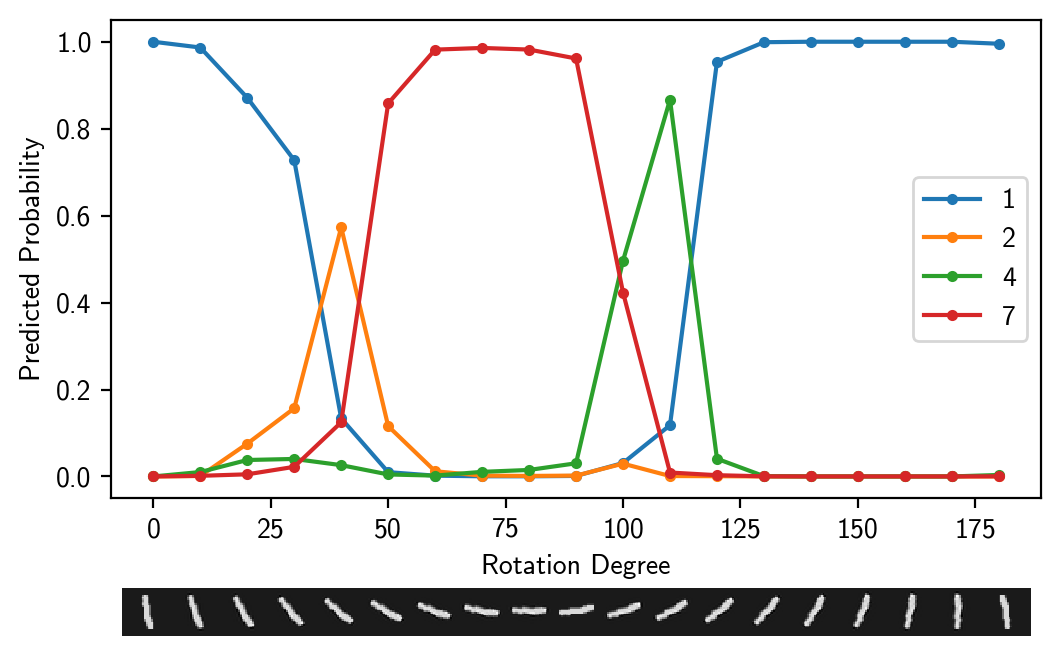

In [36]:
import scipy.ndimage as ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable

angles = np.linspace(0, 180, 19)
rotated_ones = np.stack([ndimage.rotate(train_dataset.dataset.data[6].float() / 255., angle=angle, reshape=False) for angle in angles], axis=0)
rotated_ones = torch.from_numpy(rotated_ones).unsqueeze(1)
logits = model.predict(rotated_ones.cuda(), ref_images, ref_labels, n_samples=100)
probs = F.softmax(logits, dim=-1).detach().cpu().numpy()

fig, ax0 = plt.subplots(1, 1, figsize=(6, 4), sharex='col')
for idx in np.arange(10)[probs.mean(axis=0) > 0.05]:
    ax0.plot(angles, probs[:, idx], marker='.', label=idx)
ax0.legend()
ax0.set_xlabel('Rotation Degree')
ax0.set_ylabel('Predicted Probability')

div0 = make_axes_locatable(ax0)
cax0 = div0.new_vertical(size="10%", pad=0.45, pack_start=True)
fig.add_axes(cax0)
cax0.imshow(rotated_ones.permute(2, 0, 3, 1).reshape(28, -1), cmap='gray')
cax0.axis('off');

In [ ]:
# import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from torchvision import datasets, transforms

import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.signal import savgol_filter


def logitexp(logp):
    # Convert log probability to logits (see https://github.com/pytorch/pytorch/issues/4007)
    pos = torch.clamp(logp, min=-0.69314718056)
    neg = torch.clamp(logp, max=-0.69314718056)
    neg_val = neg - torch.log(1 - torch.exp(neg))
    pos_val = -torch.log(torch.clamp(torch.expm1(-pos), min=1e-20))
    return pos_val + neg_val


class RegressionFNP(nn.Module):
    def __init__(self, dim_x=1, dim_y=1, dim_h=50, transf_y=None, n_layers=1, use_plus=True, num_M=100, dim_u=1, dim_z=1, fb_z=0.0):
        """
        :param dim_x: Dimensionality of the input
        :param dim_y: Dimensionality of the output
        :param dim_h: Dimensionality of the hidden layers
        :param transf_y: Transformation of the output (e.g. standardization)
        :param n_layers: How many hidden layers to use
        :param use_plus: Whether to use the FNP+
        :param num_M: How many points exist in the training set that are not part of the reference set
        :param dim_u: Dimensionality of the latents in the embedding space
        :param dim_z: Dimensionality of the  latents that summarize the parents
        :param fb_z: How many free bits do we allow for the latent variable z
        """
        super().__init__()
        self.dim_x, self.dim_y, self.dim_h, self.dim_u, self.dim_z = dim_x, dim_y, dim_h, dim_u, dim_z
        self.num_M, self.use_plus, self.fb_z = num_M, use_plus, fb_z

        init = [nn.Linear(dim_x, self.dim_h), nn.ReLU()]
        for i in range(n_layers - 1):
            init += [nn.Linear(self.dim_h, self.dim_h), nn.ReLU()]
        self.x_encoder = nn.Sequential(*init)
        self.p_u = nn.Linear(self.dim_h, 2 * self.dim_u)
        self.q_z = nn.Linear(self.dim_h, 2 * self.dim_z)

        self.y_encoder = nn.Linear(self.dim_y, 2 * self.dim_z)
        self.register_buffer("lambda_z", torch.tensor(1e-8))

        self.transf_y = transf_y

        # For computing edge probabilities
        self.pairwise_g_logscale = nn.Parameter(torch.tensor(1.0 * dim_u).sqrt().log())

        # p(y|z) or p(y|z, u)
        self.output = nn.Sequential(nn.Linear(self.dim_z if not self.use_plus else self.dim_z + self.dim_u, self.dim_h), nn.ReLU(), nn.Linear(self.dim_h, 2 * dim_y))

    def forward(self, XR, yR, XM, yM, kl_anneal=1.0):
        # Encode input images
        H_all = self.x_encoder(torch.cat([XR, XM], dim=0))

        # Approximate p(u | x) with a factorized Gaussian and draw a sample to construct a dependency graph
        pu_mean_all, pu_logscale_all = self.p_u(H_all).chunk(2, dim=1)
        pu = D.Normal(loc=pu_mean_all, scale=pu_logscale_all.exp())
        u = pu.rsample()

        # Compute soft adjacency matrices describing the dependency graph between
        # (1) samples from the reference set, denoted by G, using a stochastic ordering,
        # (2) samples from the current batch and those frm the reference set, denoted by A.
        G = self.sample_DAG(u[0 : XR.size(0)])
        A = self.sample_bipartite(u[XR.size(0) :], u[0 : XR.size(0)])

        # Approximate p(z | x) with a factorized Gaussian (prior distribution?)
        qz_mean_all, qz_logscale_all = self.q_z(H_all).chunk(2, dim=1)
        qz = D.Normal(loc=qz_mean_all, scale=qz_logscale_all.exp())
        z = qz.rsample()

        # Embed labels of reference points with another Gaussian
        cond_y_mean, cond_y_logscale = self.y_encoder(yR).chunk(2, dim=1)

        # For each point, gather label signals from its parent
        GA = F.normalize(torch.cat([G, A], dim=0), p=1, dim=1)
        pz_mean_all = torch.mm(GA, cond_y_mean + qz_mean_all[0 : XR.size(0)])
        pz_logscale_all = torch.mm(GA, cond_y_logscale + qz_logscale_all[0 : XR.size(0)])
        pz = D.Normal(loc=pz_mean_all, scale=pz_logscale_all.exp())

        # Compute KL(p(z | x) || q(z | x, yR))
        pqz_all = pz.log_prob(z) - qz.log_prob(z)

        # Apply free bits for the latent z
        if self.fb_z > 0:
            log_qpz = -torch.sum(pqz_all)
            if self.training:
                if log_qpz.item() > self.fb_z * z.size(0) * z.size(1) * (1 + 0.05):
                    self.lambda_z = torch.clamp(self.lambda_z * (1 + 0.1), min=1e-8, max=1.0)
                elif log_qpz.item() < self.fb_z * z.size(0) * z.size(1):
                    self.lambda_z = torch.clamp(self.lambda_z * (1 - 0.1), min=1e-8, max=1.0)
            log_pqz_R = self.lambda_z * torch.sum(pqz_all[0 : XR.size(0)])
            log_pqz_M = self.lambda_z * torch.sum(pqz_all[XR.size(0) :])
        else:
            log_pqz_R = torch.sum(pqz_all[0 : XR.size(0)])
            log_pqz_M = torch.sum(pqz_all[XR.size(0) :])

        final_rep = z if not self.use_plus else torch.cat([z, u], dim=1)
        mean_y, logstd_y = self.output(final_rep).chunk(2, dim=1)
        logstd_y = torch.log(0.1 + 0.9 * F.softplus(logstd_y))

        mean_yR, mean_yM = mean_y[0 : XR.size(0)], mean_y[XR.size(0) :]
        logstd_yR, logstd_yM = logstd_y[0 : XR.size(0)], logstd_y[XR.size(0) :]
        log_pyR = D.Normal(loc=mean_yR, scale=logstd_yR.exp()).log_prob(yR).sum()
        log_pyM = D.Normal(loc=mean_yM, scale=logstd_yM.exp()).log_prob(yM).sum()

        obj_R = (log_pyR + log_pqz_R) / float(self.num_M)
        obj_M = (log_pyM + log_pqz_M) / float(XM.size(0))
        loss = -(obj_R + obj_M)
        return loss

    def predict(self, x_new, XR, yR, sample=True):
        H_all = self.x_encoder(torch.cat([XR, x_new], 0))
        pu_mean_all, pu_logscale_all = self.p_u(H_all).chunk(2, dim=1)
        pu = D.Normal(loc=pu_mean_all, scale=pu_logscale_all.exp())
        u = pu.rsample()

        A = self.sample_bipartite(u[XR.size(0) :], u[0 : XR.size(0)])
        A_norm = F.normalize(A, p=1, dim=1)

        pz_mean_all, pz_logscale_all = self.q_z(H_all[0 : XR.size(0)]).chunk(2, dim=1)
        cond_y_mean, cond_y_logscale = self.y_encoder(yR).chunk(2, dim=1)

        pz_mean_all = torch.mm(A_norm, cond_y_mean + pz_mean_all)
        pz_logscale_all = torch.mm(A_norm, cond_y_logscale + pz_logscale_all)
        pz = D.Normal(loc=pz_mean_all, scale=pz_logscale_all.exp())

        z = pz.rsample()
        final_rep = z if not self.use_plus else torch.cat([z, u[XR.size(0) :]], dim=1)
        mean_y, logstd_y = self.output(final_rep).chunk(2, dim=1)
        logstd_y = torch.log(0.1 + 0.9 * F.softplus(logstd_y))

        init_y = D.Normal(loc=mean_y, scale=logstd_y.exp())
        y_new_i = init_y.sample() if sample else mean_y
        y_pred = y_new_i

        if self.transf_y is not None:
            if torch.cuda.is_available():
                y_pred = self.transf_y.inverse_transform(y_pred.cpu().data.numpy())
            else:
                y_pred = self.transf_y.inverse_transform(y_pred.data.numpy())
        return y_pred

    def sample_DAG(self, Z, temperature=0.3):
        idx_utr = np.triu_indices(Z.size(0), 1)

        # Sort the latents according to the stochastic ordering
        ordering = (0.5 + 0.5 * torch.erf(Z / np.sqrt(2.0))).log().sum(dim=1, keepdim=True)
        sort_idx = torch.sort(torch.squeeze(ordering), 0)[1]
        Y = Z[sort_idx, :]

        # Get the logits for the edges in the DAG
        Z1, Z2 = Y[idx_utr[0]], Y[idx_utr[1]]
        logits = logitexp((-0.5 * ((Z1 - Z2) ** 2).sum(dim=1, keepdims=True) / self.pairwise_g_logscale.exp()).view(Z1.size(0), 1))

        if self.training:
            p_edges = D.relaxed_bernoulli.LogitRelaxedBernoulli(logits=logits, temperature=temperature)
            G = torch.sigmoid(p_edges.rsample())
        else:
            p_edges = D.Bernoulli(logits=logits)
            G = p_edges.sample()

        # Embed the upper triangular to the adjacency matrix
        unsorted_G = Z.new(Z.size(0), Z.size(0)).zero_()
        unsorted_G[idx_utr[0], idx_utr[1]] = G.squeeze()

        # Unsort the dag to conform to the data order
        original_idx = torch.sort(sort_idx)[1]
        unsorted_G = unsorted_G[original_idx, :][:, original_idx]
        return unsorted_G

    def sample_bipartite(self, Z1, Z2, temperature=0.3):
        indices = torch.cartesian_prod(torch.arange(len(Z1)), torch.arange(len(Z2)))
        Y1, Y2 = Z1[indices[:, 0]], Z2[indices[:, 1]]
        logits = logitexp((-0.5 * ((Y1 - Y2) ** 2).sum(dim=1, keepdims=True) / self.pairwise_g_logscale.exp()).view(Y1.size(0), 1))

        if self.training:
            p_edges = D.relaxed_bernoulli.LogitRelaxedBernoulli(logits=logits, temperature=temperature)
            A_vals = torch.sigmoid(p_edges.rsample())
        else:
            p_edges = D.Bernoulli(logits=logits)
            A_vals = p_edges.sample()

        # Embed the values to the adjacency matrix
        A = Z1.new(Z1.size(0), Z2.size(0)).zero_()
        A[indices[:, 0], indices[:, 1]] = A_vals.squeeze()
        return A

In [21]:
def visualize(model, dx, stdx, stdy, cond_x=None, cond_y=None, all_x=None, all_y=None, samples=30, range_y=(-100.0, 100.0), title="", train=False):
    dxy = np.zeros((dx.shape[0], samples))
    if not train:
        model.eval()
    with torch.no_grad():
        dxi = torch.from_numpy(stdx.transform(dx).astype(np.float32)).cuda()
        for j in range(samples):
            dxy[:, j] = model.predict(dxi, cond_x, cond_y).ravel()

    plt.figure()
    mean_dxy, std_dxy = dxy.mean(axis=1), dxy.std(axis=1)
    # smooth it in order to avoid the sampling jitter
    mean_dxys = savgol_filter(mean_dxy, 61, 3)
    std_dxys = savgol_filter(std_dxy, 61, 3)

    if torch.cuda.is_available():
        all_x, all_y, cond_x, cond_y = all_x.cpu(), all_y.cpu(), cond_x.cpu(), cond_y.cpu()

    plt.plot(dx.ravel(), mean_dxys, label="Mean function")
    plt.plot(stdx.inverse_transform(all_x.data.numpy()).ravel(), stdy.inverse_transform(all_y.data.numpy()).ravel(), "o", label="Observations")
    if cond_x is not None:
        plt.plot(stdx.inverse_transform(cond_x.data.numpy()).ravel(), stdy.inverse_transform(cond_y.data.numpy()).ravel(), "o", label="Reference")
    plt.fill_between(dx.ravel(), mean_dxys - 1.0 * std_dxys, mean_dxys + 1.0 * std_dxys, alpha=0.1)
    plt.fill_between(dx.ravel(), mean_dxys - 2.0 * std_dxys, mean_dxys + 2.0 * std_dxys, alpha=0.1)
    plt.fill_between(dx.ravel(), mean_dxys - 3.0 * std_dxys, mean_dxys + 3.0 * std_dxys, alpha=0.1)

    plt.xlim([np.min(dx), np.max(dx)])
    plt.ylim(range_y)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.10), ncol=3, fancybox=False, shadow=False)
    plt.title(title)
    model.train()
    plt.show()

Epoch 000: loss 3.334


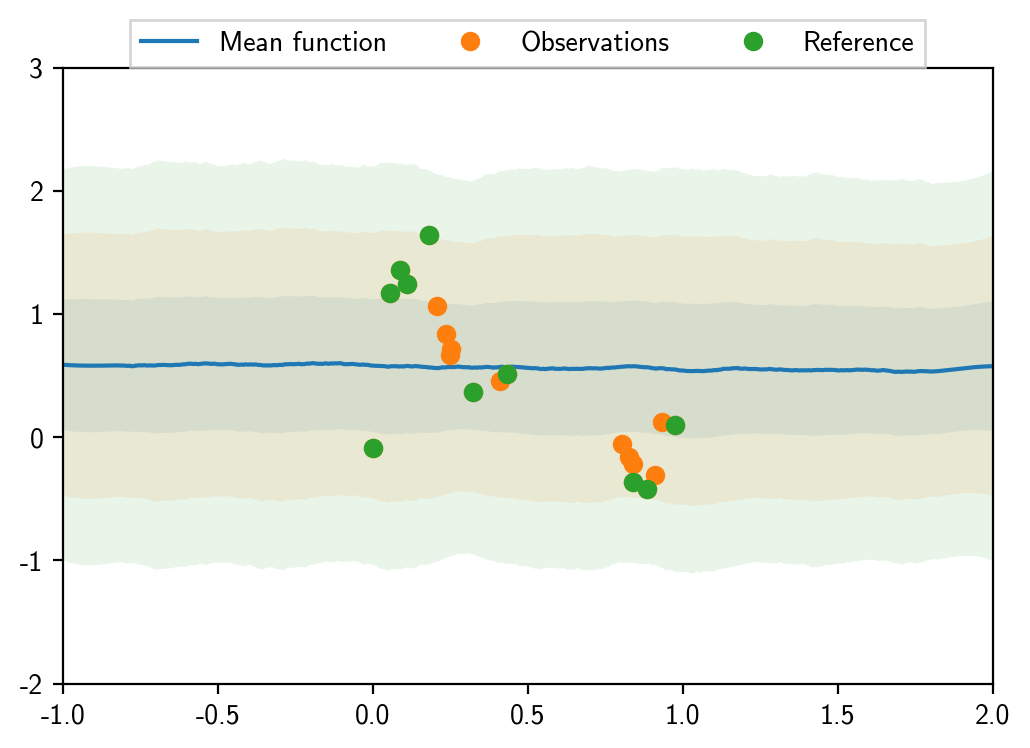

Epoch 500: loss -0.390


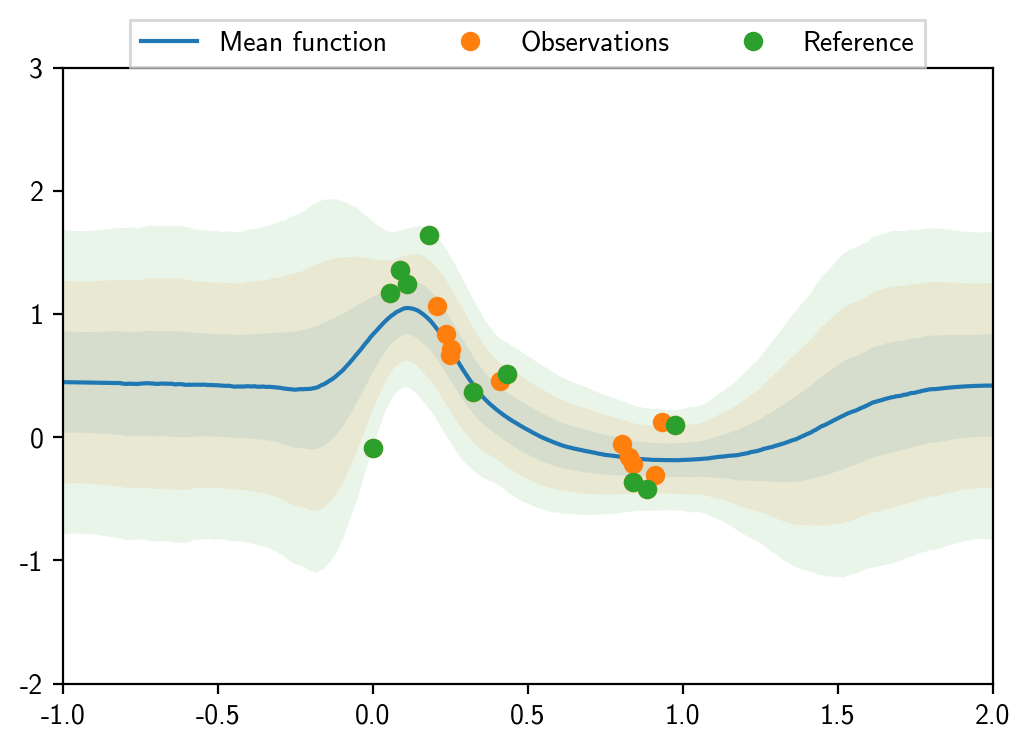

Epoch 1000: loss -0.232


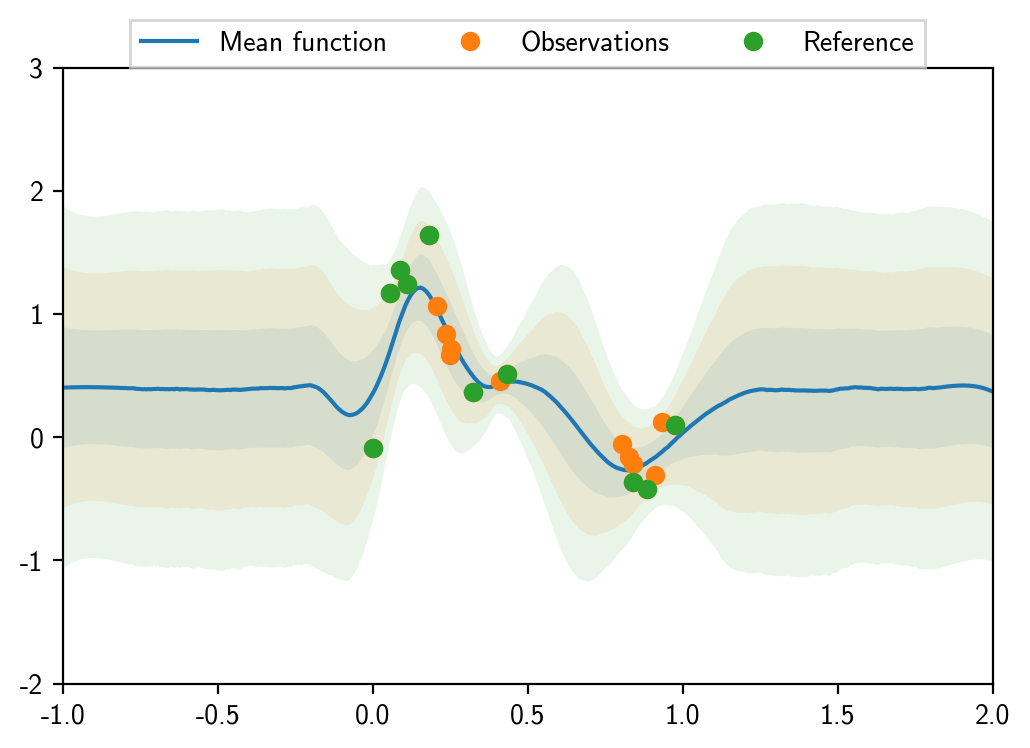

Epoch 1500: loss -2.427


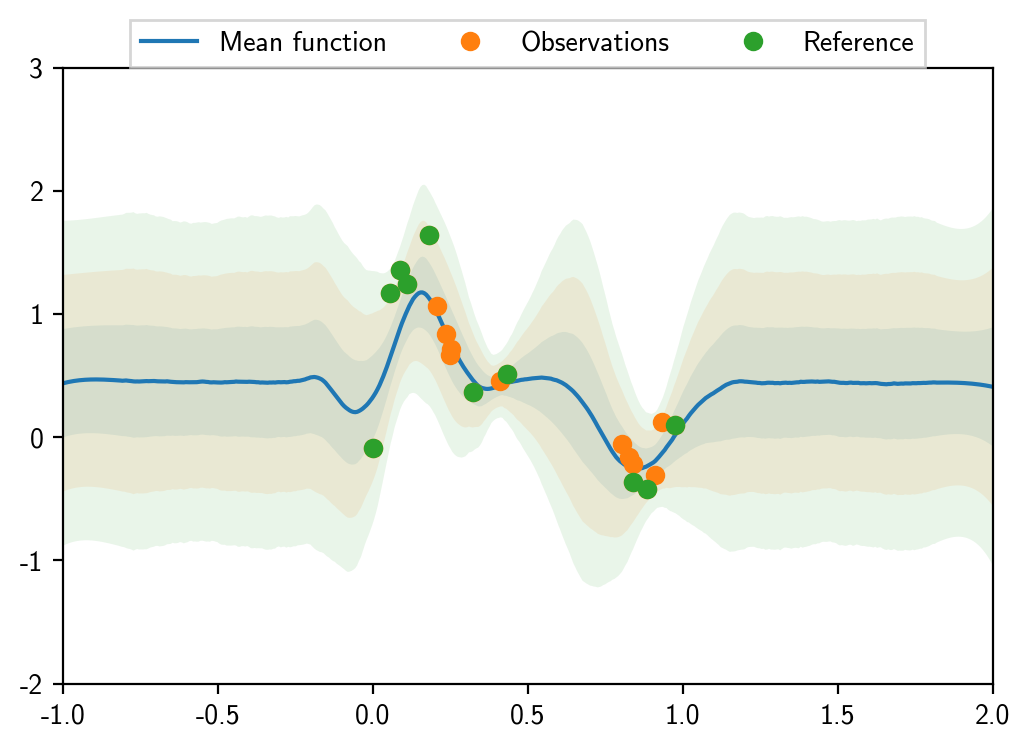

In [24]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

torch.manual_seed(0)
np.random.seed(1)
N = 20
X = np.concatenate([np.random.uniform(low=0, high=0.6, size=(N - 8, 1)), np.random.uniform(low=0.8, high=1.0, size=(8, 1))], axis=0)
eps = np.random.normal(0.0, 0.03, size=(X.shape[0], 1))
y = X + np.sin(4 * (X + eps)) + np.sin(13 * (X + eps)) + eps
stdx, stdy = StandardScaler().fit(X), StandardScaler().fit(y)
X, y = stdx.transform(X), stdy.transform(y)
X, y = X.astype(np.float32), y.astype(np.float32)

# XM, XR, yM, yR = train_test_split(X, y, test_size=0.5)
idx = np.arange(X.shape[0])
idxR = np.random.choice(idx, size=(10,), replace=False)
idxM = np.array([i for i in idx if i not in idxR.tolist()])
XR, yR, XM, yM = X[idxR], y[idxR], X[idxM], y[idxM]
XR, XM, X = torch.from_numpy(XR).cuda(), torch.from_numpy(XM).cuda(), torch.from_numpy(X).cuda()
yR, yM, y = torch.from_numpy(yR).cuda(), torch.from_numpy(yM).cuda(), torch.from_numpy(y).cuda()

model = RegressionFNP(dim_x=1, dim_y=1, transf_y=stdy, dim_h=100, dim_u=3, n_layers=1, num_M=XM.size(0), dim_z=50, fb_z=1.0, use_plus=False).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
dx = np.linspace(-1.0, 2.0, 500).astype(np.float32)[:, np.newaxis]

for epoch in range(2000):
    loss = model(XR, yR, XM, yM)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print("Epoch {:03d}: loss {:.3f}".format(epoch, loss.item()))
        visualize(model, dx, stdx, stdy, cond_x=XR, cond_y=yR, all_x=X, all_y=y, range_y=(-2., 3.), samples=100)

In [2]:
from IPython.core.display import HTML
HTML(open('../css/custom.css', 'r').read())